# 3장

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
X, y = mnist['data'], mnist['target'].astype(np.uint8)
print(X.shape, y.shape)


(70000, 784) (70000,)


5


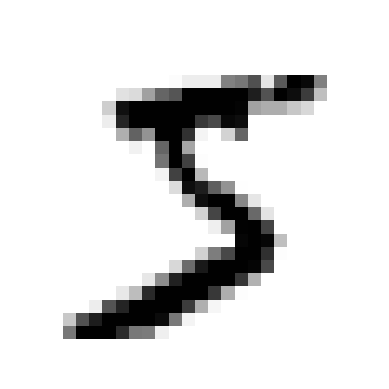

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
print(y[0])
plt.show(block=False)
plt.pause(2)
plt.close()

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone  # 모델의 학습 결과는 복제하지 않음

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [7]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy'))

[0.95035 0.96035 0.9604 ]


In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [9]:
never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy'))

[0.91125 0.90855 0.90915]


In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(confusion_matrix(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]


In [11]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


In [12]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

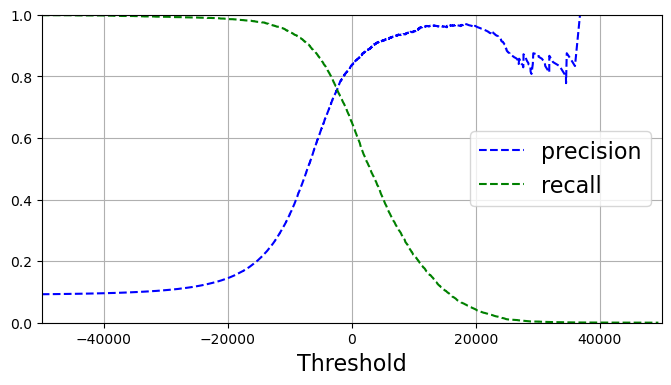

In [13]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show(block=False)
plt.pause(2)
plt.close()

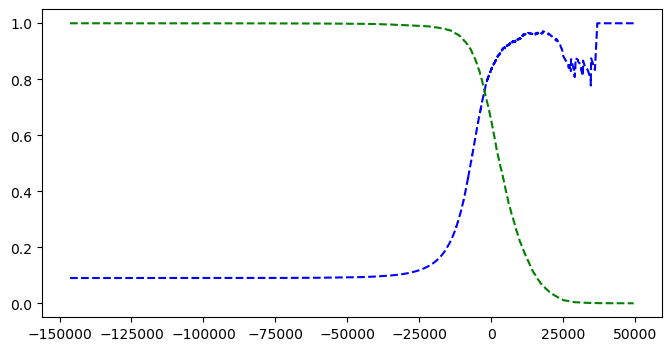

In [14]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
    # plt.legend(loc="center right", fontsize=16) # Not shown in the book
    # plt.xlabel("Threshold", fontsize=16)        # Not shown
    # plt.grid(True)                              # Not shown
    # plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show(block=False)
plt.pause(2)
plt.close()

In [15]:
from sklearn.metrics import precision_score, recall_score

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


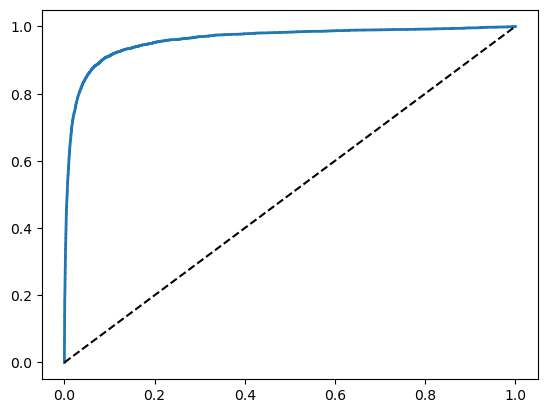

0.9604938554008616


In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show(block=False)
plt.pause(2)
plt.close()

print(roc_auc_score(y_train_5, y_scores))

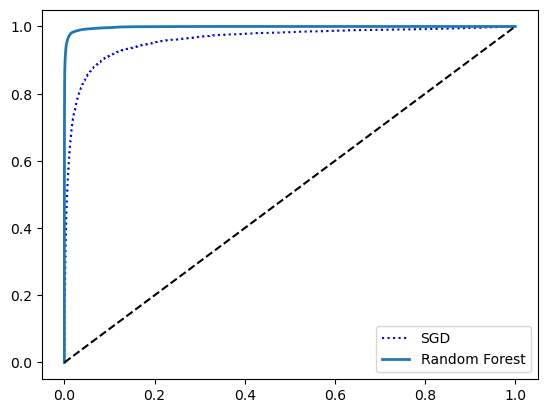

0.9983436731328145


In [17]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show(block=False)
plt.pause(2)
plt.close()

print(roc_auc_score(y_train_5, y_scores_forest))

In [18]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print(svm_clf.predict([some_digit]))

some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[5]
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


In [19]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
svm_clf.classes_[np.argmax(some_digit_scores)]

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


5

In [20]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(), n_jobs=-1)
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
print(ovr_clf.estimators_)
print(len(ovr_clf.estimators_))

[5]
[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]
10


In [21]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function([some_digit]))
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))

[3]
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
[0.87365 0.85835 0.8689 ]


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

[0.8983 0.891  0.9018]


In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


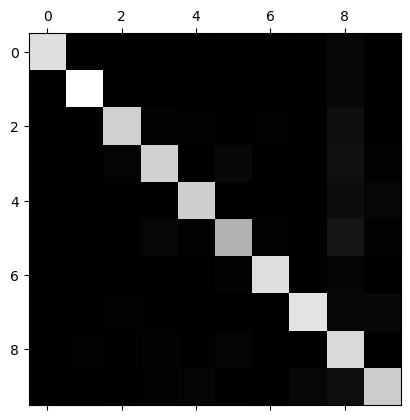

In [24]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show(block=False)
plt.pause(2)
plt.close()

In [25]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
print(row_sums)
print(norm_conf_mx)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[[9.41583657e-01 0.00000000e+00 3.71433395e-03 8.44166807e-04
  1.35066689e-03 7.25983454e-03 6.07800101e-03 1.01300017e-03
  3.79875063e-02 1.68833361e-04]
 [0.00000000e+00 9.49273213e-01 5.48798576e-03 3.55977455e-03
  5.93295758e-04 6.52625334e-03 5.93295758e-04 1.03826758e-03
  3.14446752e-02 1.48323939e-03]
 [4.53172205e-03 4.53172205e-03 8.76132931e-01 1.54414233e-02
  1.22524337e-02 4.53172205e-03 1.12453844e-02 6.04229607e-03
  6.34441088e-02 1.84625713e-03]
 [3.58832164e-03 2.77279400e-03 1.90833469e-02 8.52552602e-01
  3.26211059e-04 3.31104224e-02 4.40384929e-03 6.52422117e-03
  6.57315283e-02 1.19067036e-02]
 [2.05409106e-03 2.39643958e-03 7.01814447e-03 1.54056830e-03
  8.87024991e-01 2.05409106e-03 5.81992468e-03 4.62170490e-03
  5.93974666e-02 2.80725779e-02]
 [4.98063088e-03 2.76701716e-03 5.53403431e-03 3.09905921e-02
  9.77679395e-03 8.19774949e-01 1.38350858e-02 2.58254935e-03
  9.869027

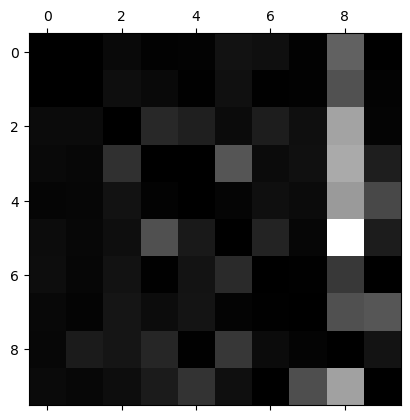

In [26]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show(block=False)
plt.pause(2)
plt.close()

In [27]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = int(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

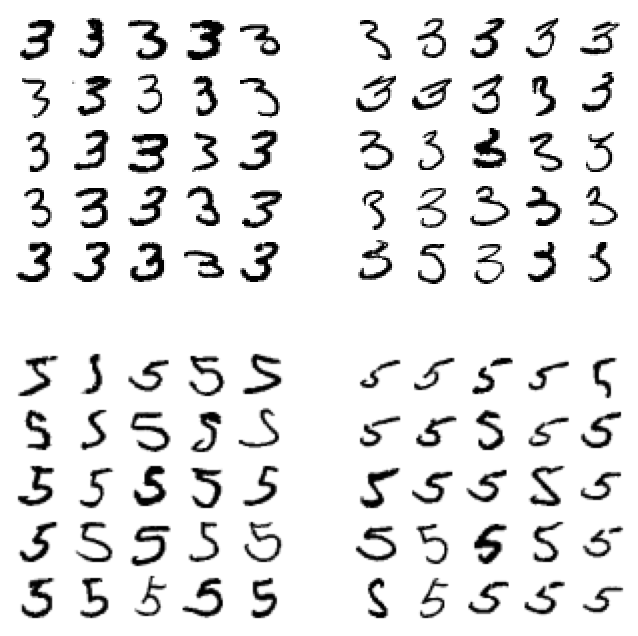

In [28]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
for idx, arr in enumerate([X_aa, X_ab, X_ba, X_bb], 221):
    plt.subplot(idx)
    plot_digits(arr[:25], images_per_row=5)
plt.show(block=False)
plt.pause(2)
plt.close()

In [30]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print(knn_clf.predict([some_digit]))

[[False  True]]


In [31]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average='macro'))

0.9764102655606048


In [32]:
noise = np.random.randint(0, 100, (len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

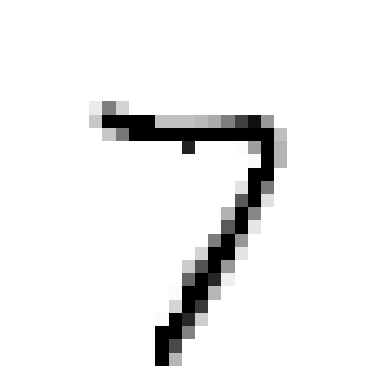

In [34]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## 연습문제 구현

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()


params = {'n_neighbors': [5, 7, 10], 'weights': ['uniform', 'distance']}


grid_search = GridSearchCV(knn_clf, params, cv=5,
                           scoring='accuracy', n_jobs=-1,
                           return_train_score=True, error_score='raise')

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'